### RAG from scratch!

In [15]:
%pip list 

Package                                  Version
---------------------------------------- -----------
accelerate                               0.34.0
aiohappyeyeballs                         2.4.0
aiohttp                                  3.10.5
aiosignal                                1.3.1
altair                                   5.4.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.2.0
appnope                                  0.1.4
argon2-cffi                              21.3.0
argon2-cffi-bindings                     21.2.0
asgiref                                  3.8.1
asttokens                                2.4.1
async-lru                                2.0.4
attrs                                    23.1.0
Babel                                    2.11.0
backoff                                  2.2.1
bcrypt                                   4.2.0
beautifulsoup4                           4.12.

In [4]:
import os 

project_dir = os.path.dirname(os.getcwd())
pdf_dir = os.path.join(project_dir, 'pdfs')

In [6]:
abs_pdf_path = os.path.join(pdf_dir, 'health.pdf')
url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

In [8]:
import requests

if not os.path.exists(abs_pdf_path):
    print("Pdf file does not exist.")
    response = requests.get(url)
    if response.status_code == 200:
        with open(abs_pdf_path, 'wb') as f:
            f.write(response.content)
        print("Pdf file has been downloaded successfully.")
    else:
        print("Could not download Pdf file.")
else:
    print("Pdf file already exists.")

Pdf file does not exist.
Pdf file has been downloaded successfully.


In [9]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str):
    cleaned_text = text.replace("\n", "").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str):
    docs = fitz.open(pdf_path)
    page_and_text = []
    for page_number, page in tqdm(enumerate(docs)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        page_and_text.append({"page_number": page_number - 41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,
                                "text": text})
    return page_and_text

In [11]:
pages_and_texts = open_and_read_pdf(pdf_path=abs_pdf_path)
type(pages_and_texts), type(pages_and_texts[0])

0it [00:00, ?it/s]

(list, dict)

In [12]:
pages_and_texts[:2]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [13]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 204,
  'page_char_count': 1795,
  'page_word_count': 265,
  'page_sentence_count_raw': 14,
  'page_token_count': 448.75,
  'text': 'whole-grain foods, fish, poultry, and nuts are emphasized while red meats, sweets, and sugar-containing beverages are mostly avoided. In this study, people on the low-sodium (1500 milligrams per day) DASH diet had mean systolic blood pressures that were 7.1 mmHg lower than people without hypertension not on the DASH diet. The effect on blood pressure was greatest in participants with hypertension at the beginning of the study who followed the DASH diet. Their systolic blood pressures were, on average, 11.5 mmHg lower than participants with hypertension on the control diet.6 Following the DASH diet not only reduces sodium intake, but also increases potassium, calcium, and magnesium intake. All of these electrolytes have a positive effect on blood pressure, although the mechanisms by which they reduce blood pressure are largely unknown. Whil

In [14]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,308,42,1,77.00,Human Nutrition: 2020 Edition UNIVERSITY OF HA...
3,-38,210,30,1,52.50,Human Nutrition: 2020 Edition by University of...
4,-37,766,114,2,191.50,Contents Preface University of Hawai‘i at Māno...


In [16]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1122.01,172.31,9.97,280.50
std,348.86,551.68,86.27,6.18,137.92
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,744.00,110.00,4.00,186.00
50%,562.50,1194.00,182.50,10.00,298.50
75%,864.25,1571.25,238.00,14.00,392.81
max,1166.00,2273.00,394.00,32.00,568.25


In [19]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe("sentencizer")
## Example use 
doc = nlp("This is a sentence. This another sentence. This is the last sentence from here.")
assert len(list(doc.sents)) == 3

list(doc.sents)

[This is a sentence.,
 This another sentence.,
 This is the last sentence from here.]

In [20]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [21]:
random.sample(pages_and_texts, k=3)

[{'page_number': 7,
  'page_char_count': 1201,
  'page_word_count': 180,
  'page_sentence_count_raw': 9,
  'page_token_count': 300.25,
  'text': 'Figure 1.1 The Macronutrients: Carbohydrates, Lipids, Protein, and Water Proteins Proteins are macromolecules composed of chains of subunits called amino acids. Amino acids are simple subunits composed of carbon, oxygen, hydrogen, and nitrogen. Food sources of proteins include meats, dairy products, seafood, and a variety of different plant-based foods, most notably soy. The word protein comes from a Greek word meaning “of primary importance,” which is an apt description of these macronutrients; they are also known colloquially as the “workhorses” of life. Proteins provide four kilocalories of energy per gram; however providing energy is not protein’s most important function. Proteins provide structure to bones, muscles and skin, and play a role in conducting most of the chemical reactions that take place in the body. Scientists estimate that

In [22]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1122.01,172.31,9.97,280.50,10.32
std,348.86,551.68,86.27,6.18,137.92,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,744.00,110.00,4.00,186.00,5.00
50%,562.50,1194.00,182.50,10.00,298.50,10.00
75%,864.25,1571.25,238.00,14.00,392.81,15.00
max,1166.00,2273.00,394.00,32.00,568.25,28.00


In [23]:
num_chunks = 10

def split_list(input_list: list, slice_size: int):
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(item["sentences"], num_chunks)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [24]:
random.sample(pages_and_texts, k=3)

[{'page_number': 287,
  'page_char_count': 1179,
  'page_word_count': 167,
  'page_sentence_count_raw': 13,
  'page_token_count': 294.75,
  'text': 'and that the “FDA can never be absolutely certain of the absence of any risk from the use of any substance.”2 The FDA additionally has established ADIs for artificial sweeteners. The ADIs are the maximum amount in milligrams per kilogram of body weight considered safe to consume daily (mg/kg bw/day) and incorporates a large safety factor. The following list contains the artificial sweeteners approved for use in foods and beverages in the United States, and their ADIs: • Acesulfame potassium (Sunett, Sweet One). ADI = 15 mg/kg bw/day • Aspartame (Equal, NutraSweet). ADI = 50 mg/kg bw/day • Neotame. ADI = 18 mg/kg bw/day • Saccharin (SugarTwin, Sweet’N Low). ADI = 5 mg/kg bw/day • Sucralose (Splenda). ADI = 5 mg/kg bw/day Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook 2

In [25]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1122.01,172.31,9.97,280.50,10.32,1.53
std,348.86,551.68,86.27,6.18,137.92,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,744.00,110.00,4.00,186.00,5.00,1.00
50%,562.50,1194.00,182.50,10.00,298.50,10.00,1.00
75%,864.25,1571.25,238.00,14.00,392.81,15.00,2.00
max,1166.00,2273.00,394.00,32.00,568.25,28.00,3.00


In [26]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [28]:
random.sample(pages_and_chunks, k=3)

[{'page_number': 488,
  'sentence_chunk': 'A study published in a 2008 issue of Obesity looked at characteristics of Chinese buffet patrons. The study found that those who chose to immediately eat before browsing the buffet used larger plates, used a fork rather than chopsticks, chewed less per bite of food, and had higher BMIs than patrons who did not exhibit these behaviors.2 2.\xa0Levin BE. (2010). Developmental Gene X Environment Interactions Affecting Systems Regulating Energy 488 | Factors Affecting Energy Intake',
  'chunk_char_count': 478,
  'chunk_word_count': 75,
  'chunk_token_count': 119.5},
 {'page_number': 861,
  'sentence_chunk': 'They begin to eat solid foods that may not provide enough of this nutrient. As a result, their iron stores become diminished at a time when this nutrient is critical for brain growth and development.\xa09.\xa0Ervin, R. B., Kit, B. K., Carroll, M. D., & Ogden, C. L. (2012). Consumption of added sugar among U. S. children and adolescents, 2005-20

In [29]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,732.99,110.88,183.25
std,347.79,447.53,71.36,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,313.50,42.50,78.38
50%,586.00,744.00,112.00,186.00
75%,890.00,1117.50,172.00,279.38
max,1166.00,1830.00,296.00,457.50


In [30]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 20.0 | Text: http://pressbooks.oer.hawaii.edu/humannutrition2/?p=118  132 | The Immune System
Chunk token count: 26.5 | Text: It is stored in the rectum until it is expelled through the anus via defecation. The Digestive System | 77
Chunk token count: 28.5 | Text: 2010). EH. Net Encyclopedia.http://eh.net/?s=History+of+Food+and+Drug+RegulatioProtecting the Public Health | 1011
Chunk token count: 9.75 | Text: 920 | Older Adulthood: The Golden Years
Chunk token count: 24.25 | Text: biological, chemicals, or physical) and identify preventative 1014 | Protecting the Public Health


In [31]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [34]:
# %pip install --upgrade transformers
from transformers import logging
logging.set_verbosity_error()
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") 

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
## Example
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embeddings in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embeddings)
    print("")


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07983628e-02  3.03164423e-02 -2.01217756e-02  6.86484501e-02
 -2.55256519e-02 -8.47686734e-03 -2.07240504e-04 -6.32378086e-02
  2.81606764e-02 -3.33354436e-02  3.02633736e-02  5.30721694e-02
 -5.03527522e-02  2.62288712e-02  3.33314091e-02 -4.51577157e-02
  3.63044851e-02 -1.37120357e-03 -1.20171094e-02  1.14947008e-02
  5.04511073e-02  4.70857024e-02  2.11914033e-02  5.14606386e-02
 -2.03747042e-02 -3.58889587e-02 -6.67795015e-04 -2.94394121e-02
  4.95859347e-02 -1.05639417e-02 -1.52014401e-02 -1.31755823e-03
  4.48197462e-02  1.56023670e-02  8.60379600e-07 -1.21394766e-03
 -2.37979088e-02 -9.09360184e-04  7.34486990e-03 -2.53936765e-03
  5.23370765e-02 -4.68043759e-02  1.66214891e-02  4.71579544e-02
 -4.15599309e-02  9.01927124e-04  3.60277966e-02  3.42214070e-02
  9.68227163e-02  5.94829395e-02 -1.64984781e-02 -3.51249427e-02
  5.92521578e-03 -7.07922154e-04 -2.4103

In [37]:
%%time 

embedding_model.to("cpu")
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embeddings"] = embedding_model.encode(item["sentence_chunk"]) 

  0%|          | 0/1679 [00:00<?, ?it/s]

CPU times: user 12min 6s, sys: 1min 57s, total: 14min 3s
Wall time: 3min 42s


In [38]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks

['Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
 'Contents Preface University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxv About the Contributors University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxvi Acknowledgements University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xl Part\xa0I.\xa0Chapter 1. Basic Concepts in Nutrition Introduction University of Hawai‘i at Mānoa Food

In [40]:
%%time
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True,
                                               show_progress_bar=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

CPU times: user 10min 49s, sys: 2min 11s, total: 13min 1s
Wall time: 3min 30s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]])

In [41]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = os.path.join(os.path.join(project_dir, "CSV_db"), "text_chunks_and_embeddings_df.csv")
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [42]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

page_number  \
0          -39   
1          -38   
2          -37   
3          -36   
4          -35   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           sentence_chunk  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.   
2                                                                                                                                                                                                                                          Contents Preface University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxv About the Contributors University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxvi Acknowledgements University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xl Part I. Chapter 1. Basic Concepts in Nutrition Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 3 Food Quality University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 

In [45]:
import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv(embeddings_df_save_path)

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embeddings"] = text_chunks_and_embedding_df["embeddings"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embeddings"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1679, 768])

In [46]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embeddings
0,-39,"Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE",308,42,77.00,"[0.0674242452, 0.0902280211, -0.00509549212, -0.0317545533, 0.07390818, 0.0351976231, -0.0197987594, 0.0467692129, 0.0535726957, 0.00501232082, 0.033392854, -0.00162223447, 0.0176081266, 0.036265377, -0.000316715654, -0.0107117416, 0.0154257976, 0.0262177326, 0.00277663185, 0.0364942737, -0.0444109701, 0.0189362187, 0.0490117408, 0.0164020676, -0.0485783555, 0.0031828545, 0.0272992365, -0.00204747147, -0.0122828828, -0.0728048682, 0.0120446235, 0.0107299872, 0.00209995871, -0.0817773044, 2.67830092e-06, -0.0181429069, -0.0120803462, 0.0247174986, -0.0627467185, 0.0735437348, 0.0221624747, -0.0328768492, -0.0180095527, 0.0222952403, 0.0561365411, 0.00179510948, 0.0525932014, -0.00331740081, -0.00833879504, -0.0106284926, 0.00231921743, -0.0223934054, -0.0153010739, -0.0099305287, 0.0465321839, 0.0357469022, -0.025475977, 0.0263694674, 0.00374914915, -0.0382680297, 0.0258325636, 0.0412872508, 0.0258181691, 0.0332972109, -0.0251783393, 0.0451521054, 0.000448986248, -0.0996621177, 0.0499490835, 0.0713513419, 0.0696959347, 0.038523525, 0.0099534411, 0.0418640263, -0.0322837085, -0.0043996186, 0.0505052656, -0.0552355573, -0.0280109439, -0.0227898248, -0.0171496514, 0.0187901724, 0.0156440903, -0.00139883393, -0.00659484603, 0.030238986, 0.00637050811, 0.0196739752, -0.00415961165, -0.036431089, -0.015816642, 0.0232676007, 0.000268584321, 0.0217785444, 0.00689115888, -0.0232419353, 0.072593987, -0.050119862, 0.0808757469, -0.0248893481, ...]"
1,-38,"Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.",210,30,52.50,"[0.0552156605, 0.059213791, -0.0166167878, -0.0204602312, 0.0692422539, 0.0351345316, -0.0187620223, 0.0321569107, 0.0778691471, -0.00806518551, 0.0260770842, 0.000117925862, 0.0236337297, 0.00699444301, 1.72613682e-06, -0.0038258885, 0.00345733785, 0.0116404919, 0.0101687443, 0.0495471582, -0.0518357269, 0.0188297965, 0.0451909602, 0.0423135236, -0.0412121974, 0.00493983133, 0.0325199105, -0.0181734338, 0.00884534325, -0.0644744858, -0.0050450922, 0.0174673107, -0.00165694114, -0.0850823969, 2.46762625e-06, -0.0169054028, 0.0109408554, 0.0301257912, -0.0666744411, 0.0621615872, 0.0350563712, -0.0247929376, -0.0159020536, 0.0237372536, 0.0393132754, 0.0406050086, 0.045144584, -0.00583530124, -0.0152490335, 0.00862983428, -0.00196107081, -0.0310200118, -0.0325586088, 0.00262659695, 0.0376191251, 0.0328164473, -0.0142092919, 0.0182541031, 0.00401725899, -0.046587076, 0.00456145825, 0.0584205389, 0.0241824891, 0.0443892069, -0.0336209834, 0.0468509421, 0.0164948199, -0.0893779472, 0.0591009632, 0.0392324924, 0.0559263714, 0.0362490043, -0.0126896631, 0.0266755912, -0.0230123755, -0.0257725921, 0.0315982811, -0.048267182, -0.0100867571, -0.0226086657, -0.0184209272, 0.0181876626, 0.0187499113, -0.00441873027, -0.00978096202, 0.0454947278, -0.00252458919, 0.0263713524, -0.015976036, -0.047384318, -0.0253288466, 0.0454882532, 0.0116945868, 0.0195937008, 0.0159996115, -0.0319499262, 0.0767784417, -0.0563972034, 0.0772039965, -0.011849666, ...]"
2,-37,Contents Preface University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxv About the Contributors University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxvi Acknowledgements University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xl Part I. Chapter 1. Basic Concepts in Nutrition 

In [48]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device='cuda' if  torch.cuda.is_available() else 'cpu') # choose the device to load the model to

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [49]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1679 embeddings: 0.00387 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6298]),
indices=tensor([42, 47, 41, 51, 52]))

In [50]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([167900, 768])
Time take to get scores on 167900 embeddings: 0.04841 seconds.


In [51]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [52]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

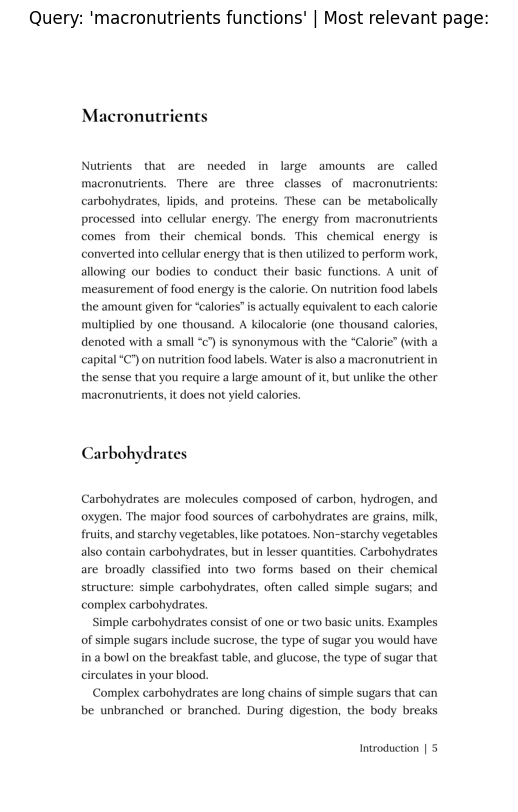

In [53]:
import fitz

# Open PDF and load target page
pdf_path = abs_pdf_path 
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [54]:
# Cosine similarity

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_prod = dot_product(vector1, vector2)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))
    
    return dot_prod / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [55]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [56]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1679 embeddings: 0.00208 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721]),
 tensor([ 822,  853, 1535, 1554, 1530]))

In [57]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1679 embeddings: 0.00150 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion. These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with the